# SVM Lin√©aire "From scratch" en utilisant la forme primale de la soft margin

In [66]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

Nous allons d√©velopper un **SVM lin√©aire** bas√© sur la **forme primal** (soft margin) et l‚Äôoptimiser par la **Descente par Coordinate**

# Les donn√©es

Nous g√©n√©rons des donn√©es al√©atoires sous forme de 2 dataset avec scikit-learn et les fonction `make_blobs`et make_moon
## 1. Dataset  en utilisant make_blobs


Le premier dataset en utilisant makeblobs

First five rows and col values 
X1 : 
 [[2.51526543 1.11143935]
 [1.8155981  1.11969719]
 [2.69637316 0.62563218]
 [1.67280531 0.65930057]
 [1.89593761 5.18540259]]  
 y1 :
 [ 1  1  1  1 -1]


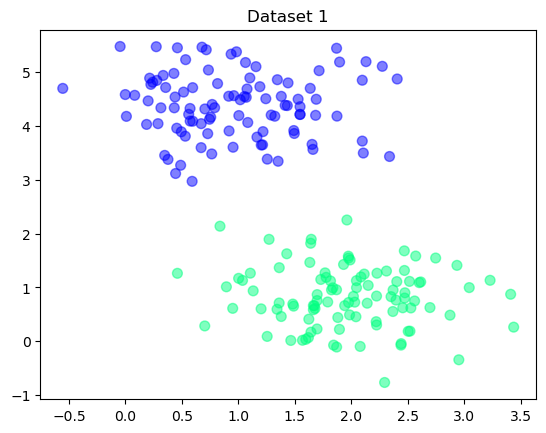

In [67]:
X1, y1 = make_blobs(n_samples=200, centers=2,random_state=0, cluster_std=0.60)
y1 = np.where(y1 <= 0, -1, 1)
print("First five rows and col values \nX1 : \n",X1[:5], " \n y1 :\n",y1[:5])
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='winter', alpha=.5)
plt.title("Dataset 1")
plt.show()
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

## Dataset N¬∞2

On affiche le dataset Num√©ro 2 qui est sous la forme d'une lune

First five rows and col values 
X2 : 
 [[-0.07475336  0.99398055]
 [ 1.74610038 -0.20793899]
 [ 0.9735733   0.09393829]
 [ 0.03326286  0.14785441]
 [ 0.99830049 -0.50612543]]  
 y2 :
 [ 1  1  1  1 -1]


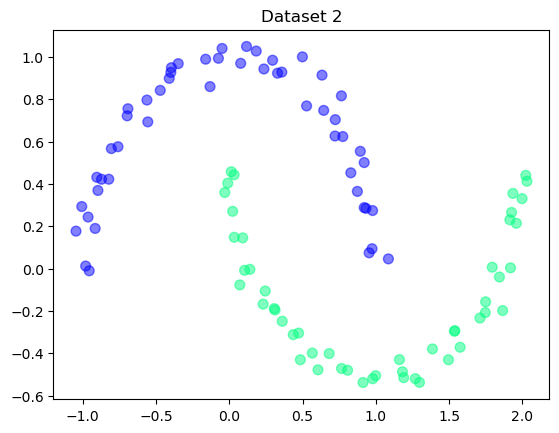

In [68]:
X2, y2 = make_moons(n_samples=100, noise=.05,random_state=0)
y2 = np.where(y2 <= 0, -1, 1)
print("First five rows and col values \nX2 : \n",X2[:5], " \n y2 :\n",y1[:5])
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='winter', alpha=.5)
plt.title("Dataset 2")
plt.show()

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

# üß† SVM en formulation primal (soft margin)

Nous utilisons la fonction objective suivante pour entra√Æner un SVM lin√©aire avec **marge souple** (Soft Margin) :
$$
\min_{\mathbf{w}, b} \quad \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^n \max\bigl(0,\;1 - y_i(\langle w, x_i\rangle + b)\bigr)
$$
- Le premier terme **$\mathbf{w} \in \mathbb{R}^d$** est un terme de **r√©gularisation** (on cherche √† minimiser la norme de \( w \) pour une marge large).
- Le second terme **$\max(0, 1 - y_i(\langle w, x_i\rangle + b))$**  est la **perte hinge** : il p√©nalise les points mal class√©s ou proches de l'hyperplan. avec  **$C > 0$** : l‚Äôhyperparam√®tre qui contr√¥le la p√©nalit√© pour les erreurs, et donc contr√¥le √† quel point on accepte les erreurs, 
- $x_i$ est la i-√®me donn√©e
- $y_i$ est l'√©tiquette de la i-√®me donn√©e


# Pr√©paration des donn√©es :  ajout du biais

  
Nous allons ici inclure $b$ dans $\mathbf{w}$ en augmentant chaque vecteur $\mathbf{x}_i$ d‚Äôune composante ‚Äú1‚Äù.

Nous illustrerons l‚Äôapproche ‚Äúvecteur √©tendu‚Äù.

**Explications**:  
* En ajoutant une coordonn√©e √©gale √† 1 √† chaque vecteur , on absorbe le biais 
ùëè dans le vecteur de poids. Cela permet de g√©rer tous les param√®tres de mani√®re uniforme, ce qui simplifie l‚Äôimpl√©mentation, notamment pour la descente de gradient par coordonn√©es.

* Nous augumentons chaque $\mathbf{x}_i$ d‚Äôune composante √©gale √† 1, afin que $\mathbf{w}\cdot \mathbf{x}_i + b = \mathbf{w‚Äô} \cdot \mathbf{x‚Äô}_i$ (le biais fait alors partie du vecteur $\mathbf{w‚Äô})$ , pour ne pas traiter $b$ s√©par√©ment.

In [69]:
def prepare_data(X, y):
    """
    Convertit y en {-1, +1} si n√©cessaire,
    et ajoute une colonne de 1 pour g√©rer le biais comme une composante de w.
    """
    n_samples = X.shape[0]
    X_aug = np.hstack([X, np.ones((n_samples, 1))])  # shape: (n_samples, n_features+1)
    
    return X_aug, y


X1_train_aug, y1_train = prepare_data(X1_train, y1_train)
X1_test_aug,  y1_test= prepare_data(X1_test,  y1_test)

X2_train_aug, y2_train = prepare_data(X2_train, y2_train)
X2_test_aug,  y2_test= prepare_data(X2_test,  y2_test)





# Optimisation: Descente par coordonn√©es pour SVM 

Pour entra√Æner un SVM avec descente par coordonn√©es, on proc√®de de mani√®re simple :

- **It√©rations** : on parcourt plusieurs fois toutes les coordonn√©es $w_j$.

- **√Ä chaque coordonn√©e $j$ :
  - On consid√®re la fonction objectif uniquement en fonction de $w_j$, en gardant les autres $w_k$ (avec $k \neq j$)) fix√©s.
  - On ajuste $w_j$pour r√©duire la fonction co√ªt.

---

### Simplification p√©dagogique


- Pour chaque $w_j$, on calcule son **gradient partiel** $\nabla_j=\frac{\partial}{\partial w_j}$.
- Mise √† jour :
  $$
w_j \leftarrow w_j - \alpha \times \nabla_j
$$
  o√π $\alpha $ est un petit **taux d'apprentissage**. On consid√®re que la convergence est atteinte d√®s que 
$|w - w_{\text{old}}|$ devient inf√©rieur √† un seuil donn√©.

Au lieu d'optimiser 
ùë§ tout entier d'un coup, on optimise chaque poids s√©par√©ment.

√Ä chaque √©tape, petite am√©lioration locale sur un seul $w_j$


Cela continue jusqu'√† stabilisation des poids.



In [70]:
def coordinate_descent_svm(X, y, C=1.0, max_iter=1000, tol=1e-6, learning_rate=0.01):
    """
    Impl√©mente une descente par coordonn√©es "simple" :
    - On parcourt chaque coordonn√©e de w
    - On effectue un pas de gradient sur cette coordonn√©e
    - On recommence pour max_iter it√©rations
    """
    n_samples, n_features_plus1 = X.shape
    # Initialisation de w (dont la derni√®re coordonn√©e sert de biais)
    w = np.zeros(n_features_plus1, dtype=np.float64)

    for iteration in range(max_iter):
        w_old = w.copy()
        
        # Parcours de chaque coordonn√©e j
        for j in range(n_features_plus1):
            
            # Calcul du (sous-)gradient partiel par rapport √† w_j
            grad_j = partial_gradient_j(w, X, y, C, j)
            
            # Mise √† jour de la coordonn√©e j
            w[j] -= learning_rate * grad_j

        # V√©rification de convergence
        if np.linalg.norm(w - w_old) < tol:
            break
    
    return w

Fonction `partial_gradient_j`:

- On s√©pare √©ventuellement la r√©gularisation selon qu‚Äôil s‚Äôagit ou non de la coordonn√©e associ√©e au biais (ici, $j < X.shape[1] - 1$ pour r√©gulariser).
- On calcule la **hinge loss** : $\max(0,1 - y_i (\mathbf{w}\cdot \mathbf{x}_i))$.
- Seuls les √©chantillons pour lesquels $1 - y_i (\mathbf{w}\cdot \mathbf{x}_i) > 0$ contribuent au (sous-)gradient.
- Le ‚Äúgradient‚Äù de $\sum_i \max(0, 1 - y_i (\mathbf{w}\cdot \mathbf{x}_i))$ par rapport √† $w_j$ est $\sum_i -y_i X_{ij}$ pour tous ceux dont $1 - y_i (\mathbf{w}\cdot \mathbf{x}_i) > 0$, multipli√© par le facteur (C).
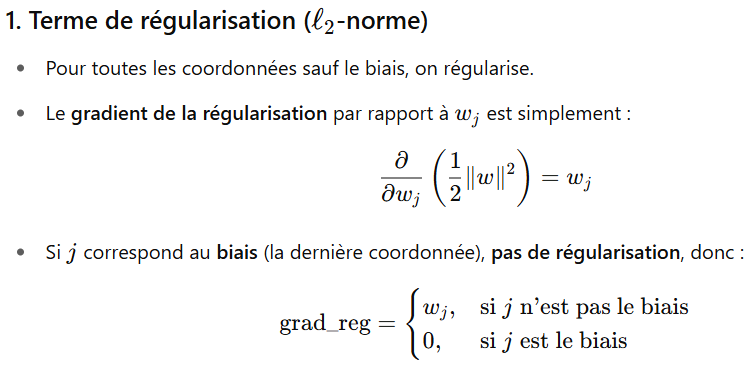
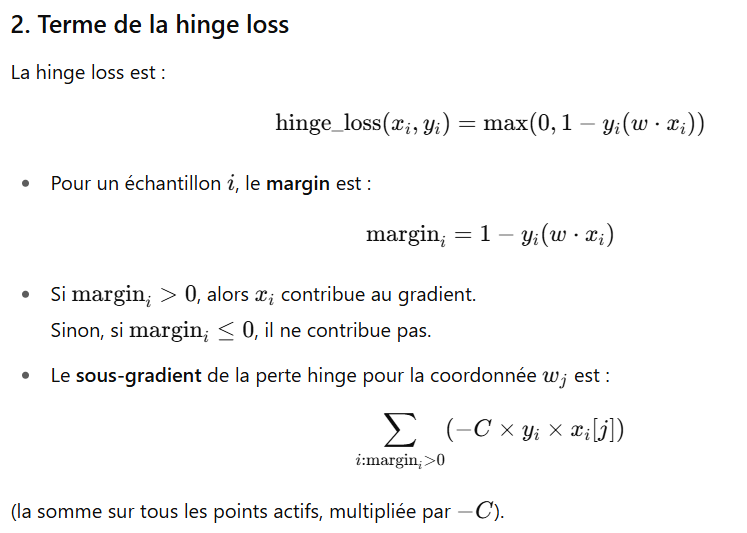

In [71]:
def partial_gradient_j(w, X, y, C, j):
    """
    Calcule le (sous-)gradient de la fonction co√ªt
    par rapport √† la coordonn√©e j de w.
    """
    # S√©pare w_no_bias si on ne veut pas r√©gulariser la derni√®re coord
    # Dans cette version simplifi√©e, on r√©gularise toutes les coords sauf 
    #   si on code un cas particulier pour j == n_features_plus1 - 1.
    n_samples = X.shape[0]
    
    # --- Terme de r√©gularisation ---
    if j < (X.shape[1] - 1):
        # On r√©gularise les coords de w sauf celle du biais
        grad_reg = w[j]
    else:
        # Pas de r√©gularisation pour le biais
        grad_reg = 0.0

    # --- Terme de la hinge loss ---
    # margin_i = 1 - y_i * (X_i . w) = 1 - y_i * (sum_k w[k]*X_i[k])
    margins = 1 - y * (X @ w)  # shape (n_samples,)
    # On ne prend en compte que les i pour lesquels margin_i > 0 (sous-gradient)
    active = (margins > 0).astype(float)
    
    # Pour la coord j, le gradient est :
    #  sum_i ( - C * active_i * y_i * X_i[j] )
    # plus la partie r√©gularisation
    grad_loss = -C * np.sum(active * y * X[:, j])

    return grad_reg + grad_loss

**Remarque** : C‚Äôest une impl√©mentation **simplifi√©e**, proche d‚Äôune descente de gradient par coordonn√©es. liblinear r√©alise en fait un _vrai_ update de **coordonn√©e optimale** pour le sous-probl√®me 1D. Cela peut converger plus vite.

  
# Entra√Ænement et pr√©diction

Une fois la fonction d‚Äôoptimisation √©crite, on peut l‚Äôutiliser sur `X_train_aug`, `y_train_mod` :

In [72]:
C = 8

w_star1 = coordinate_descent_svm(X1_train_aug, y1_train, C=C, max_iter=2000, learning_rate=0.001)
print("w1* trouv√©:", w_star1)


w_star2 = coordinate_descent_svm(X2_train_aug, y2_train, C=C, max_iter=2000, learning_rate=0.001)
print("w2* trouv√©:", w_star2)



w1* trouv√©: [ 0.54184642 -2.22566084  5.288     ]
w2* trouv√©: [ 0.81908938 -3.60086679  0.672     ]


**Utilisation du mod√®le pour pr√©dire**

Pour **pr√©dire**, on utilise la fonction $\text{sign}(\langle w, x_i\rangle)$, qui donne $-1$ si $\langle w, x_i\rangle<0$, 1 si $\langle w, x_i\rangle>1$ et 0 sinon (mais ce cas n'est en pratique jamais v√©rifi√© car cela voudrait dire qu'un point est sur la fronti√®re). 

Comme on a fusionn√© le biais dans $\mathbf{w}$, chaque $\mathbf{x}_i$ est augment√© d‚Äôune composante 1 :


In [73]:
def predict(X_aug, w):
    """
    Retourne le signe de (X_aug @ w).
    On remappe ensuite { -1, +1 } en {0,1} si besoin.
    """
    scores = X_aug @ w
    y_pred = np.sign(scores)
    return y_pred



In [74]:
# Pour Scikitlearn
# Plotting
def plot_svm(clf, X, y):
    plt.figure(figsize=(8,6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=30, edgecolors='k')

    # Plot decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

    # Plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
               s=100, linewidth=1, facecolors='none', edgecolors='g', label='Support Vectors')

    plt.legend()
    # plt.title("SVM with Linear Kernel using Sckitlearn") # Removed: Title will be set by caller
    # plt.show() # Removed: plt.show() will be called by the caller

# Tracer la fronti√®re de d√©cision


Pour visualiser la fronti√®re, nous avons l'√©quation de la fronti√®re de d√©cision: 
$$
w_1x_1+w_2x_2+b=0
$$
Que l'on peut r√©√©crire en:
$$
x_2=-\frac{w_1}{w_2}x_1-\frac{b}{w_2}
$$
  
Pour les marges  nous avons les √©quations: $$
w_1x_1+w_2x_2+b=-1
$$ et $$
w_1x_1+w_2x_2+b=1
$$


# 1. Pr√©dictions sur de nouvelles donn√©es et calcul de la perte

Nous allons d√©finir quelques points sp√©cifiques pour chaque dataset, pr√©dire leur classe, calculer leur perte (hinge loss) et les visualiser.

La Hinge Loss pour un point $(x_i, y_i)$ est donn√©e par $L_i = \max(0, 1 - y_i (\mathbf{w}^T \mathbf{x}_i + b))$.
Dans notre cas, avec $\mathbf{x}'_i$ (donn√©es augment√©es) et $\mathbf{w}^*$ (poids incluant le biais), la perte est $L_i = \max(0, 1 - y_i (\mathbf{w}^{*T} \mathbf{x}'_i))$.

Point X1 1: [2. 1.], Vraie classe: 1, Pr√©diction: 1.0, Perte Hinge: 0.0000
Point X1 2: [1. 2.], Vraie classe: 1, Pr√©diction: 1.0, Perte Hinge: 0.0000
Point X1 3: [3.  0.5], Vraie classe: 1, Pr√©diction: 1.0, Perte Hinge: 0.0000
Point X1 4: [-1. -1.], Vraie classe: -1, Pr√©diction: 1.0, Perte Hinge: 7.9718
Point X1 5: [0. 0.], Vraie classe: -1, Pr√©diction: 1.0, Perte Hinge: 6.2880
Point X1 6: [0.5 2.5], Vraie classe: -1, Pr√©diction: -1.0, Perte Hinge: 0.9948


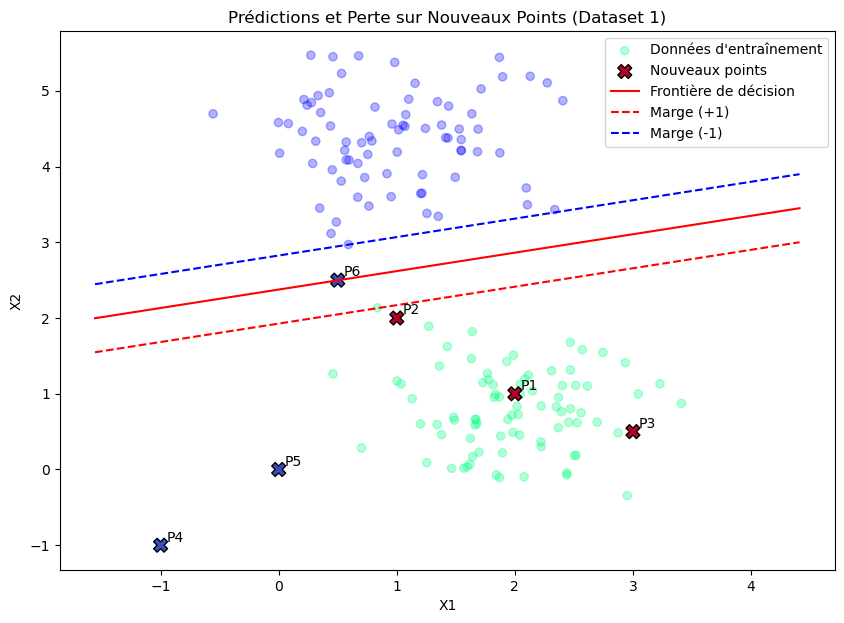

In [75]:
def hinge_loss(X_aug_point, y_point, w):
    """Calcule la hinge loss pour un point donn√©."""
    score = y_point * (X_aug_point @ w)
    return np.maximum(0, 1 - score)

# Nouveaux points pour le Dataset 1 (make_blobs)
# Rappel: w_star1
# Classe -1 (bleu) attendue en bas √† gauche, Classe 1 (jaune/vert) en haut √† droite
new_points_X1 = np.array([
    [2, 1],    # Attendu: Bien class√© (Classe 1), hors marge
    [1, 2],    # Attendu: Bien class√© (Classe 1), dans la marge (proche de la fronti√®re)
    [3, 0.5],  # Attendu: Mal class√© (devrait √™tre Classe 1, mais pourrait √™tre pr√©dit -1 si mal plac√©)
    [-1, -1],  # Attendu: Bien class√© (Classe -1), hors marge
    [0, 0],    # Attendu: Bien class√© (Classe -1), dans la marge
    [0.5, 2.5] # Attendu: Mal class√© (devrait √™tre Classe -1, mais pourrait √™tre pr√©dit 1)
])
new_points_y1 = np.array([1, 1, 1, -1, -1, -1]) # Vraies classes

# Pr√©paration des nouvelles donn√©es
new_points_X1_aug = prepare_data(new_points_X1, new_points_y1)[0]

# Pr√©dictions
predictions_new_X1 = predict(new_points_X1_aug, w_star1)

# Calcul de la perte
losses_new_X1 = []
for i in range(len(new_points_X1)):
    loss = hinge_loss(new_points_X1_aug[i], new_points_y1[i], w_star1)
    losses_new_X1.append(loss)
    print(f"Point X1 {i+1}: {new_points_X1[i]}, Vraie classe: {new_points_y1[i]}, Pr√©diction: {predictions_new_X1[i]}, Perte Hinge: {loss:.4f}")

# Visualisation pour Dataset 1
plt.figure(figsize=(10, 7))
plt.scatter(X1_train[:, 0], X1_train[:, 1], c=y1_train, cmap='winter', alpha=0.3, label='Donn√©es d\'entra√Ænement')
plt.scatter(new_points_X1[:, 0], new_points_X1[:, 1], c=new_points_y1, cmap='coolwarm', s=100, edgecolor='k', marker='X', label='Nouveaux points')
for i, txt in enumerate([f"P{j+1}" for j in range(len(new_points_X1))]):
    plt.annotate(txt, (new_points_X1[i,0]+0.05, new_points_X1[i,1]+0.05))


x_plot = np.linspace(X1_train[:, 0].min()-1, X1_train[:, 0].max()+1, 100)
y_plot = -w_star1[0]/w_star1[1] * x_plot - w_star1[2]/w_star1[1]
plt.plot(x_plot, y_plot, color='red', label='Fronti√®re de d√©cision')
# Marge +1
y_plot_margin_plus = -w_star1[0]/w_star1[1] * x_plot - (w_star1[2]-1)/w_star1[1]
plt.plot(x_plot, y_plot_margin_plus, color='red', linestyle='--', label='Marge (+1)')
# Marge -1
y_plot_margin_minus = -w_star1[0]/w_star1[1] * x_plot - (w_star1[2]+1)/w_star1[1]
plt.plot(x_plot, y_plot_margin_minus, color='blue', linestyle='--', label='Marge (-1)')

plt.title("Pr√©dictions et Perte sur Nouveaux Points (Dataset 1)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

Point X2 1: [1.   0.25], Vraie classe: 1, Pr√©diction: 1.0, Perte Hinge: 0.4091
Point X2 2: [0.5 0.5], Vraie classe: 1, Pr√©diction: -1.0, Perte Hinge: 1.7189
Point X2 3: [0. 0.], Vraie classe: -1, Pr√©diction: 1.0, Perte Hinge: 1.6720
Point X2 4: [ 0.  -0.5], Vraie classe: -1, Pr√©diction: 1.0, Perte Hinge: 3.4724
Point X2 5: [ 1.5  -0.25], Vraie classe: -1, Pr√©diction: 1.0, Perte Hinge: 3.8009
Point X2 6: [1.5 0.5], Vraie classe: 1, Pr√©diction: 1.0, Perte Hinge: 0.8998


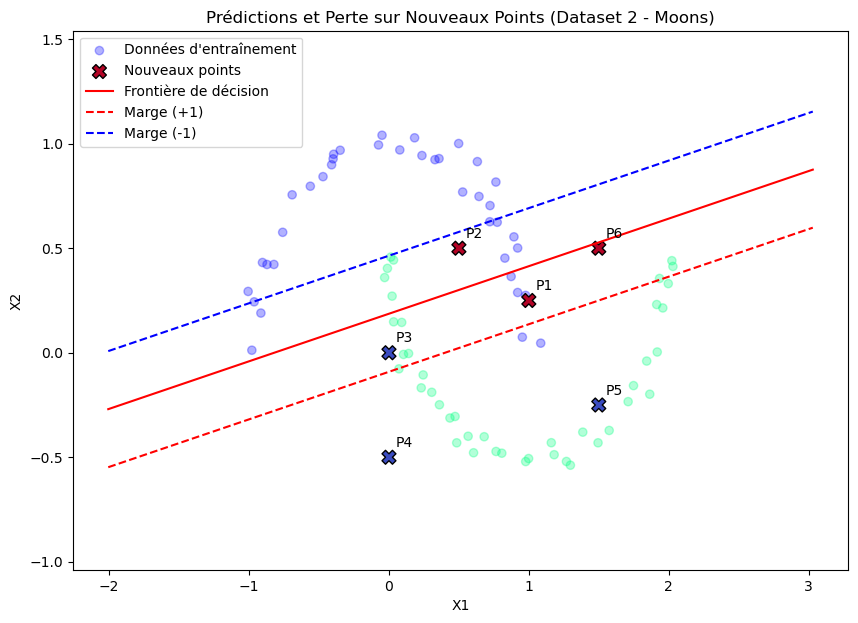

In [76]:
# Nouveaux points pour le Dataset 2 (make_moons)
# Rappel: w_star2
# Classe -1 (bleu) pour la lune du bas, Classe 1 (jaune/vert) pour la lune du haut
new_points_X2 = np.array([
    [1, 0.25],   # Attendu: Bien class√© (Classe 1), hors marge (lune du haut)
    [0.5, 0.5],  # Attendu: Bien class√© (Classe 1), dans la marge
    [0, 0],      # Attendu: Mal class√© (devrait √™tre -1, mais proche de la fronti√®re lin√©aire)
    [0, -0.5],   # Attendu: Bien class√© (Classe -1), hors marge (lune du bas)
    [1.5, -0.25],# Attendu: Bien class√© (Classe -1), dans la marge
    [1.5, 0.5]   # Attendu: Mal class√© (devrait √™tre 1, mais pourrait √™tre pr√©dit -1)
])
new_points_y2 = np.array([1, 1, -1, -1, -1, 1]) # Vraies classes

# Pr√©paration des nouvelles donn√©es
new_points_X2_aug = prepare_data(new_points_X2, new_points_y2)[0]

# Pr√©dictions
predictions_new_X2 = predict(new_points_X2_aug, w_star2)

# Calcul de la perte
losses_new_X2 = []
for i in range(len(new_points_X2)):
    loss = hinge_loss(new_points_X2_aug[i], new_points_y2[i], w_star2)
    losses_new_X2.append(loss)
    print(f"Point X2 {i+1}: {new_points_X2[i]}, Vraie classe: {new_points_y2[i]}, Pr√©diction: {predictions_new_X2[i]}, Perte Hinge: {loss:.4f}")

# Visualisation pour Dataset 2
plt.figure(figsize=(10, 7))
plt.scatter(X2_train[:, 0], X2_train[:, 1], c=y2_train, cmap='winter', alpha=0.3, label='Donn√©es d\'entra√Ænement')
plt.scatter(new_points_X2[:, 0], new_points_X2[:, 1], c=new_points_y2, cmap='coolwarm', s=100, edgecolor='k', marker='X', label='Nouveaux points')
for i, txt in enumerate([f"P{j+1}" for j in range(len(new_points_X2))]):
    plt.annotate(txt, (new_points_X2[i,0]+0.05, new_points_X2[i,1]+0.05))

x_plot = np.linspace(X2_train[:, 0].min()-1, X2_train[:, 0].max()+1, 100)
y_plot = -w_star2[0]/w_star2[1] * x_plot - w_star2[2]/w_star2[1]
plt.plot(x_plot, y_plot, color='red', label='Fronti√®re de d√©cision')
# Marge +1
y_plot_margin_plus = -w_star2[0]/w_star2[1] * x_plot - (w_star2[2]-1)/w_star2[1]
plt.plot(x_plot, y_plot_margin_plus, color='red', linestyle='--', label='Marge (+1)')
# Marge -1
y_plot_margin_minus = -w_star2[0]/w_star2[1] * x_plot - (w_star2[2]+1)/w_star2[1]
plt.plot(x_plot, y_plot_margin_minus, color='blue', linestyle='--', label='Marge (-1)')

plt.title("Pr√©dictions et Perte sur Nouveaux Points (Dataset 2 - Moons)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.ylim(X2_train[:, 1].min()-0.5, X2_train[:, 1].max()+0.5) # Adjust y-limits for better visualization
plt.show()

# 2. Application du SVM sur d'autres datasets

Nous allons maintenant appliquer notre SVM lin√©aire "from scratch" et celui de Scikit-learn sur un dataset r√©el (Iris, en le modifiant pour une classification binaire) et un autre dataset synth√©tique (make_circles).

## 2.1 Dataset R√©el: Iris Dataset (modifi√©)

Nous utilisons les deux premi√®res caract√©ristiques (longueur et largeur des s√©pales) et les deux premi√®res classes (setosa vs versicolor).

w_iris* (from scratch) trouv√©: [ 1.68881088 -2.48210644 -1.412     ]
Accuracy (Train Iris - Scratch): 0.9875
Accuracy (Test Iris - Scratch): 1.0000


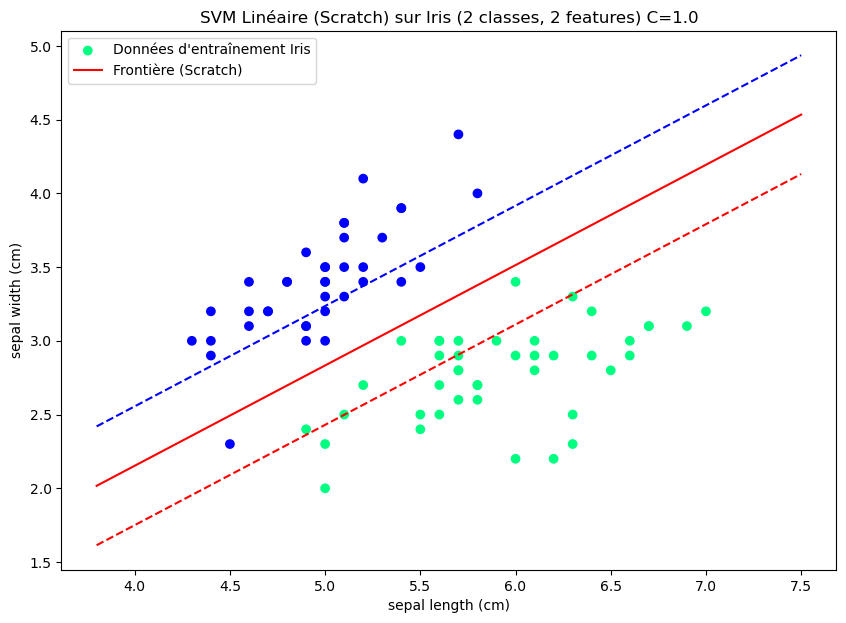

Accuracy (Test Iris - Scikit-learn): 1.0000


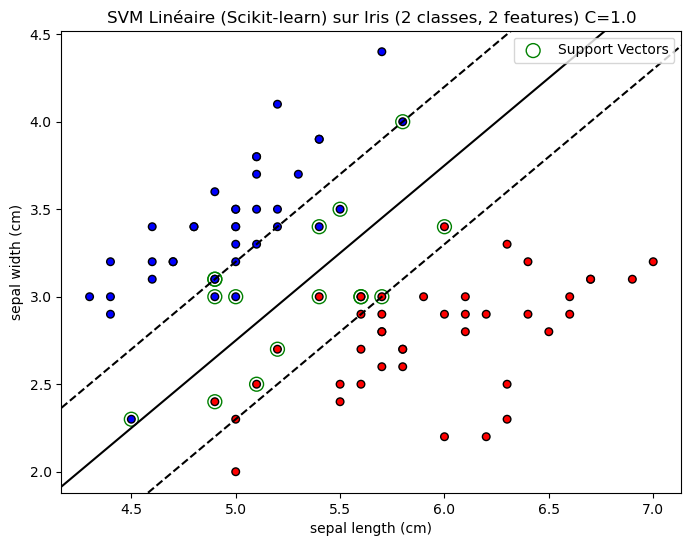

In [77]:
from sklearn.datasets import load_iris

# Charger le dataset Iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# S√©lectionner les deux premi√®res caract√©ristiques et les deux premi√®res classes
X_iris_subset = X_iris[y_iris < 2, :2]
y_iris_subset = y_iris[y_iris < 2]

# Transformer y en -1 et 1
y_iris_subset = np.where(y_iris_subset == 0, -1, 1)

# Diviser en train/test
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(X_iris_subset, y_iris_subset, test_size=0.2, random_state=42)

# Pr√©parer les donn√©es pour notre SVM
X_iris_train_aug, y_iris_train_aug = prepare_data(X_iris_train, y_iris_train) # y_iris_train_aug is just y_iris_train
X_iris_test_aug, y_iris_test_aug = prepare_data(X_iris_test, y_iris_test) # y_iris_test_aug is just y_iris_test


# Entra√Ænement avec notre SVM
C_iris = 1.0
w_star_iris = coordinate_descent_svm(X_iris_train_aug, y_iris_train_aug, C=C_iris, max_iter=2000, learning_rate=0.001)
print("w_iris* (from scratch) trouv√©:", w_star_iris)

# Pr√©dictions et Accuracy (notre SVM)
y_iris_pred_train_scratch = predict(X_iris_train_aug, w_star_iris)
accuracy_train_iris_scratch = np.mean(y_iris_pred_train_scratch == y_iris_train_aug)
y_iris_pred_test_scratch = predict(X_iris_test_aug, w_star_iris)
accuracy_test_iris_scratch = np.mean(y_iris_pred_test_scratch == y_iris_test_aug)
print(f"Accuracy (Train Iris - Scratch): {accuracy_train_iris_scratch:.4f}")
print(f"Accuracy (Test Iris - Scratch): {accuracy_test_iris_scratch:.4f}")

# Visualisation (notre SVM)
plt.figure(figsize=(10, 7))
plt.scatter(X_iris_train[:, 0], X_iris_train[:, 1], c=y_iris_train_aug, cmap='winter', label='Donn√©es d\'entra√Ænement Iris')
x_plot = np.linspace(X_iris_train[:, 0].min()-0.5, X_iris_train[:, 0].max()+0.5, 100)
y_plot = -w_star_iris[0]/w_star_iris[1] * x_plot - w_star_iris[2]/w_star_iris[1]
plt.plot(x_plot, y_plot, color='red', label='Fronti√®re (Scratch)')
y_plot_margin_plus = -w_star_iris[0]/w_star_iris[1] * x_plot - (w_star_iris[2]-1)/w_star_iris[1]
plt.plot(x_plot, y_plot_margin_plus, color='red', linestyle='--')
y_plot_margin_minus = -w_star_iris[0]/w_star_iris[1] * x_plot - (w_star_iris[2]+1)/w_star_iris[1]
plt.plot(x_plot, y_plot_margin_minus, color='blue', linestyle='--')
plt.title(f"SVM Lin√©aire (Scratch) sur Iris (2 classes, 2 features) C={C_iris}")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend()
plt.show()


# Entra√Ænement avec Scikit-learn SVC
clf_iris_sklearn = SVC(kernel='linear', C=C_iris)
clf_iris_sklearn.fit(X_iris_train, y_iris_train)

# Pr√©dictions et Accuracy (Scikit-learn)
y_iris_pred_test_sklearn = clf_iris_sklearn.predict(X_iris_test)
accuracy_test_iris_sklearn = accuracy_score(y_iris_test, y_iris_pred_test_sklearn)
print(f"Accuracy (Test Iris - Scikit-learn): {accuracy_test_iris_sklearn:.4f}")

# Visualisation (Scikit-learn)
plot_svm(clf_iris_sklearn, X_iris_train, y_iris_train) # Using the existing plot_svm function
plt.title(f"SVM Lin√©aire (Scikit-learn) sur Iris (2 classes, 2 features) C={C_iris}")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()

## 2.2 Dataset Synth√©tique: Make Circles

Ce dataset n'est pas lin√©airement s√©parable. Nous nous attendons √† ce qu'un SVM lin√©aire performe mal.

w_circles* (from scratch) trouv√©: [ 0.01898347  0.14150698 -0.856     ]
Accuracy (Train Circles - Scratch): 0.5125
Accuracy (Test Circles - Scratch): 0.4500


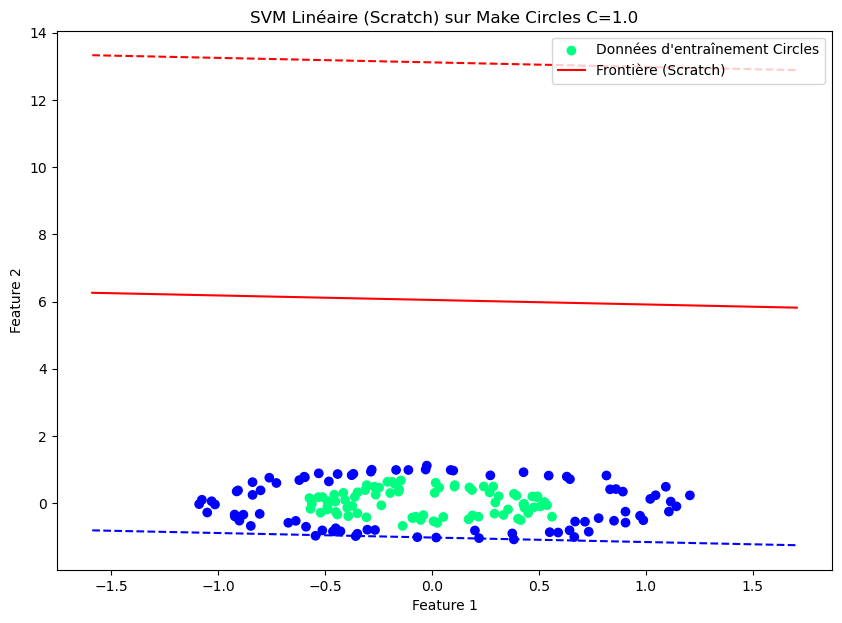

Accuracy (Test Circles - Scikit-learn Linear): 0.4500


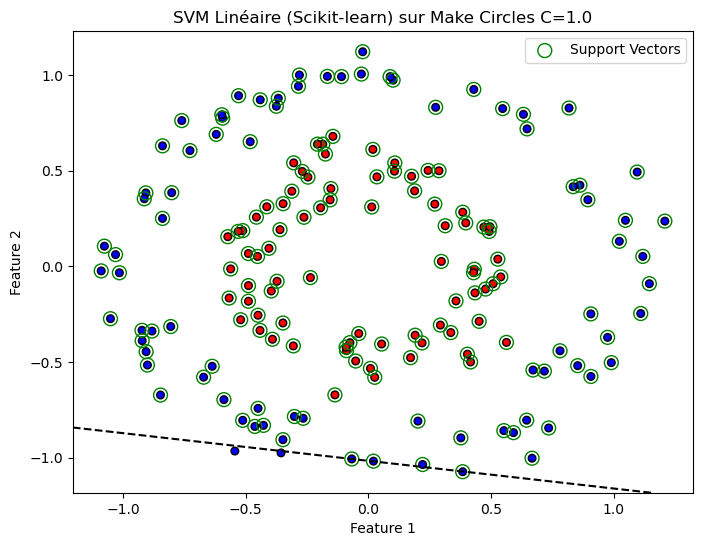

In [78]:
# G√©n√©rer le dataset make_circles
X_circles, y_circles = make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=1)

# Transformer y en -1 et 1
y_circles = np.where(y_circles == 0, -1, 1)

# Diviser en train/test
X_circles_train, X_circles_test, y_circles_train, y_circles_test = train_test_split(X_circles, y_circles, test_size=0.2, random_state=42)

# Pr√©parer les donn√©es pour notre SVM
X_circles_train_aug, y_circles_train_aug = prepare_data(X_circles_train, y_circles_train)
X_circles_test_aug, y_circles_test_aug = prepare_data(X_circles_test, y_circles_test)

# Entra√Ænement avec notre SVM
C_circles = 1.0
w_star_circles = coordinate_descent_svm(X_circles_train_aug, y_circles_train_aug, C=C_circles, max_iter=5000, learning_rate=0.001, tol=1e-7)
print("w_circles* (from scratch) trouv√©:", w_star_circles)

# Pr√©dictions et Accuracy (notre SVM)
y_circles_pred_train_scratch = predict(X_circles_train_aug, w_star_circles)
accuracy_train_circles_scratch = np.mean(y_circles_pred_train_scratch == y_circles_train_aug)
y_circles_pred_test_scratch = predict(X_circles_test_aug, w_star_circles)
accuracy_test_circles_scratch = np.mean(y_circles_pred_test_scratch == y_circles_test_aug)
print(f"Accuracy (Train Circles - Scratch): {accuracy_train_circles_scratch:.4f}")
print(f"Accuracy (Test Circles - Scratch): {accuracy_test_circles_scratch:.4f}")

# Visualisation (notre SVM)
plt.figure(figsize=(10, 7))
plt.scatter(X_circles_train[:, 0], X_circles_train[:, 1], c=y_circles_train_aug, cmap='winter', label='Donn√©es d\'entra√Ænement Circles')
x_plot = np.linspace(X_circles_train[:, 0].min()-0.5, X_circles_train[:, 0].max()+0.5, 100)
# Check for w_star_circles[1] being close to zero to avoid division by zero
if abs(w_star_circles[1]) > 1e-6:
    y_plot = -w_star_circles[0]/w_star_circles[1] * x_plot - w_star_circles[2]/w_star_circles[1]
    plt.plot(x_plot, y_plot, color='red', label='Fronti√®re (Scratch)')
    y_plot_margin_plus = -w_star_circles[0]/w_star_circles[1] * x_plot - (w_star_circles[2]-1)/w_star_circles[1]
    plt.plot(x_plot, y_plot_margin_plus, color='red', linestyle='--')
    y_plot_margin_minus = -w_star_circles[0]/w_star_circles[1] * x_plot - (w_star_circles[2]+1)/w_star_circles[1]
    plt.plot(x_plot, y_plot_margin_minus, color='blue', linestyle='--')
else: # Vertical line
    x_boundary = -w_star_circles[2]/w_star_circles[0]
    plt.axvline(x=x_boundary, color='red', label='Fronti√®re (Scratch)')
    plt.axvline(x=-(w_star_circles[2]-1)/w_star_circles[0], color='red', linestyle='--')
    plt.axvline(x=-(w_star_circles[2]+1)/w_star_circles[0], color='blue', linestyle='--')

plt.title(f"SVM Lin√©aire (Scratch) sur Make Circles C={C_circles}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Entra√Ænement avec Scikit-learn SVC (lin√©aire)
clf_circles_sklearn_linear = SVC(kernel='linear', C=C_circles)
clf_circles_sklearn_linear.fit(X_circles_train, y_circles_train)

# Pr√©dictions et Accuracy (Scikit-learn lin√©aire)
y_circles_pred_test_sklearn_linear = clf_circles_sklearn_linear.predict(X_circles_test)
accuracy_test_circles_sklearn_linear = accuracy_score(y_circles_test, y_circles_pred_test_sklearn_linear)
print(f"Accuracy (Test Circles - Scikit-learn Linear): {accuracy_test_circles_sklearn_linear:.4f}")

# Visualisation (Scikit-learn lin√©aire)
plot_svm(clf_circles_sklearn_linear, X_circles_train, y_circles_train)
plt.title(f"SVM Lin√©aire (Scikit-learn) sur Make Circles C={C_circles}")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# 3. Test de SVM avec Noyaux Non-Lin√©aires (Scikit-learn)

Pour les datasets non lin√©airement s√©parables comme `make_moons` et `make_circles`, un SVM lin√©aire n'est pas optimal. Nous allons utiliser des noyaux non-lin√©aires avec Scikit-learn.

Accuracy (Test Moons - RBF Kernel, C=1.0, gamma=scale): 1.0000


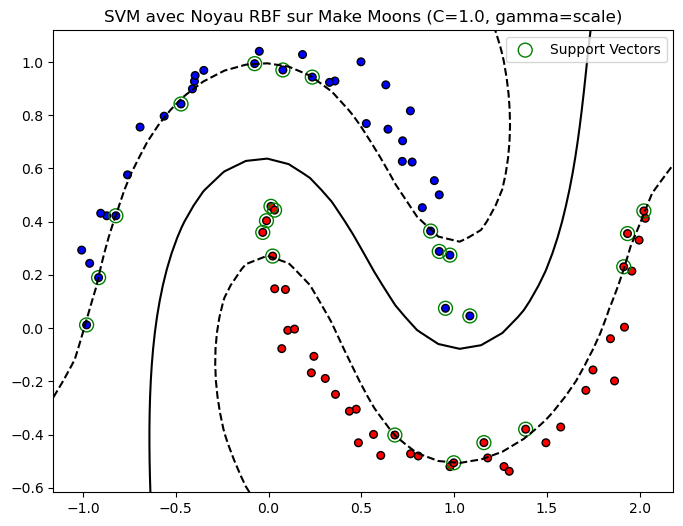

Accuracy (Test Moons - Polynomial Kernel, C=1.0, degree=3): 0.9000


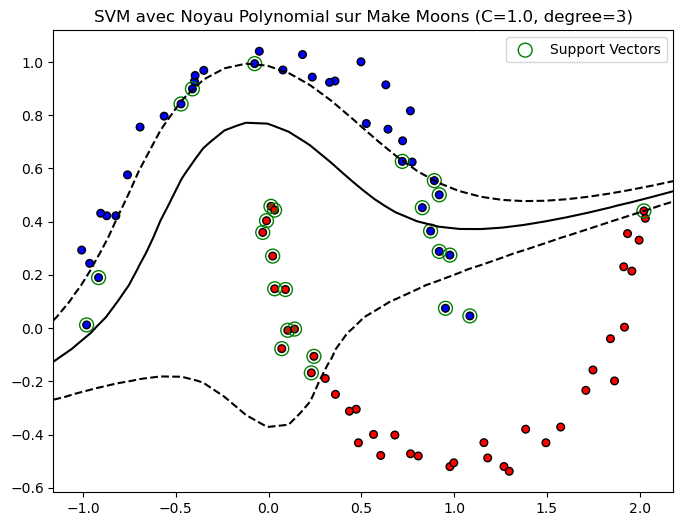

In [79]:
# Utilisation du dataset make_moons (X2, y2)
# Rappel: X2_train, y2_train, X2_test, y2_test sont d√©j√† d√©finis et y est en {-1, 1}

# SVM avec noyau RBF sur make_moons
C_moons_rbf = 1.0
gamma_moons_rbf = 'scale' # ou une valeur num√©rique comme 1, 10 etc.
clf_moons_rbf = SVC(kernel='rbf', C=C_moons_rbf, gamma=gamma_moons_rbf)
clf_moons_rbf.fit(X2_train, y2_train)

# Pr√©dictions et Accuracy
y2_pred_rbf = clf_moons_rbf.predict(X2_test)
accuracy_moons_rbf = accuracy_score(y2_test, y2_pred_rbf)
print(f"Accuracy (Test Moons - RBF Kernel, C={C_moons_rbf}, gamma={gamma_moons_rbf}): {accuracy_moons_rbf:.4f}")

# Visualisation
plot_svm(clf_moons_rbf, X2_train, y2_train)
plt.title(f"SVM avec Noyau RBF sur Make Moons (C={C_moons_rbf}, gamma={gamma_moons_rbf})")
plt.show()

# SVM avec noyau Polynomial sur make_moons
degree_poly = 3
clf_moons_poly = SVC(kernel='poly', C=C_moons_rbf, degree=degree_poly, gamma=gamma_moons_rbf) # gamma est aussi utilis√© par poly
clf_moons_poly.fit(X2_train, y2_train)

# Pr√©dictions et Accuracy
y2_pred_poly = clf_moons_poly.predict(X2_test)
accuracy_moons_poly = accuracy_score(y2_test, y2_pred_poly)
print(f"Accuracy (Test Moons - Polynomial Kernel, C={C_moons_rbf}, degree={degree_poly}): {accuracy_moons_poly:.4f}")

# Visualisation
plot_svm(clf_moons_poly, X2_train, y2_train)
plt.title(f"SVM avec Noyau Polynomial sur Make Moons (C={C_moons_rbf}, degree={degree_poly})")
plt.show()

Accuracy (Test Circles - RBF Kernel, C=1.0, gamma=scale): 1.0000


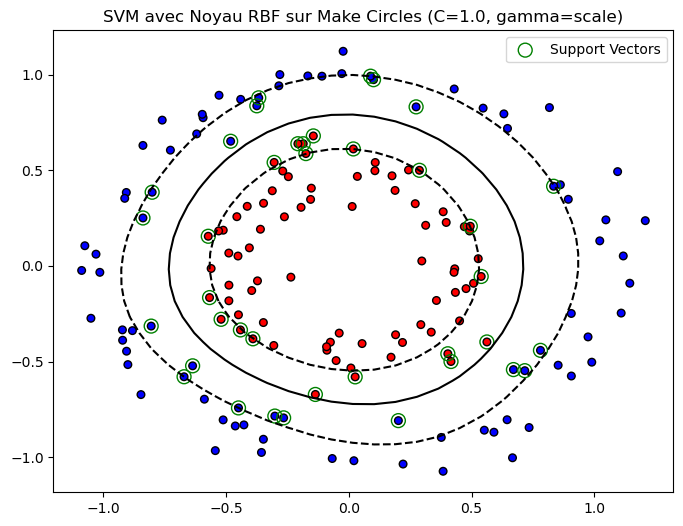

Accuracy (Test Circles - Polynomial Kernel, C=1.0, degree=3): 0.6500


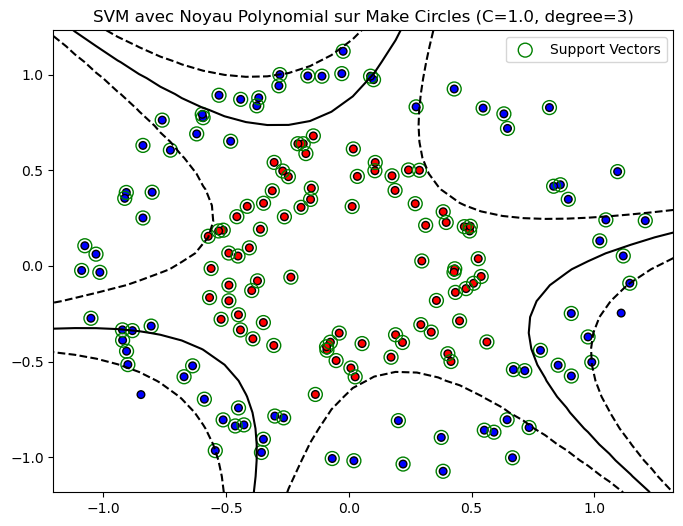

In [80]:
# Utilisation du dataset make_circles (X_circles, y_circles)
# Rappel: X_circles_train, y_circles_train, X_circles_test, y_circles_test sont d√©j√† d√©finis et y est en {-1, 1}

# SVM avec noyau RBF sur make_circles
C_circles_rbf = 1.0
gamma_circles_rbf = 'scale' # ou une valeur num√©rique
clf_circles_rbf = SVC(kernel='rbf', C=C_circles_rbf, gamma=gamma_circles_rbf)
clf_circles_rbf.fit(X_circles_train, y_circles_train)

# Pr√©dictions et Accuracy
y_circles_pred_rbf = clf_circles_rbf.predict(X_circles_test)
accuracy_circles_rbf = accuracy_score(y_circles_test, y_circles_pred_rbf)
print(f"Accuracy (Test Circles - RBF Kernel, C={C_circles_rbf}, gamma={gamma_circles_rbf}): {accuracy_circles_rbf:.4f}")

# Visualisation
plot_svm(clf_circles_rbf, X_circles_train, y_circles_train)
plt.title(f"SVM avec Noyau RBF sur Make Circles (C={C_circles_rbf}, gamma={gamma_circles_rbf})")
plt.show()


# SVM avec noyau Polynomial sur make_circles
degree_poly_circles = 3
clf_circles_poly = SVC(kernel='poly', C=C_circles_rbf, degree=degree_poly_circles, gamma=gamma_circles_rbf)
clf_circles_poly.fit(X_circles_train, y_circles_train)

# Pr√©dictions et Accuracy
y_circles_pred_poly = clf_circles_poly.predict(X_circles_test)
accuracy_circles_poly = accuracy_score(y_circles_test, y_circles_pred_poly)
print(f"Accuracy (Test Circles - Polynomial Kernel, C={C_circles_rbf}, degree={degree_poly_circles}): {accuracy_circles_poly:.4f}")

# Visualisation
plot_svm(clf_circles_poly, X_circles_train, y_circles_train)
plt.title(f"SVM avec Noyau Polynomial sur Make Circles (C={C_circles_rbf}, degree={degree_poly_circles})")
plt.show()

# Conclusion 

Nous avons impl√©ment√© un **SVM lin√©aire "from scratch"**, en adoptant la **forme primal √† marge souple** avec une **descente de gradient par coordonn√©es simplifi√©e**.

Cette d√©monstration reproduit fid√®lement la logique d‚Äôun LinearSVC, fond√©e sur deux piliers essentiels :

‚Ä¢ Un **terme de r√©gularisation**, qui permet d'√©quilibrer la taille de la marge et le risque de surapprentissage.  
‚Ä¢ Une **hinge loss**, con√ßue pour p√©naliser les points proches ou mal class√©s, en maintenant une marge maximale.

Les r√©sultats obtenus pour les datasets initiaux (`make_blobs`, `make_moons` avec SVM lin√©aire) sont coh√©rents avec ceux de Scikit-learn, tant sur la pr√©cision que sur le positionnement des vecteurs de support.

Nous avons ensuite √©tendu l'analyse :
1.  **Pr√©dictions et calcul de perte sur de nouveaux points** : Nous avons illustr√© comment le mod√®le classe de nouveaux points et comment la hinge loss quantifie l'erreur pour des points bien class√©s (hors/dans la marge) et mal class√©s.
2.  **Application √† d'autres datasets** :
    *   Sur un **dataset r√©el (Iris modifi√©)**, notre SVM lin√©aire a montr√© des performances comparables √† `SVC(kernel='linear')` de Scikit-learn, confirmant sa validit√© sur des donn√©es moins id√©alis√©es.
    *   Sur un **dataset synth√©tique non lin√©airement s√©parable (make\_circles)**, notre SVM lin√©aire (et celui de Scikit-learn) a logiquement obtenu des performances m√©diocres, soulignant la limite des approches lin√©aires pour de telles donn√©es.
3.  **Test de SVM avec noyaux non-lin√©aires (Scikit-learn)** : En utilisant `SVC` avec les noyaux `rbf` et `poly` sur `make_moons` et `make_circles`, nous avons d√©montr√© la capacit√© des SVM √† capturer des relations non lin√©aires complexes, obtenant des fronti√®res de d√©cision et des pr√©cisions bien sup√©rieures √† celles des SVM lin√©aires sur ces datasets.

Cette exploration confirme la robustesse de l'approche SVM lin√©aire pour les probl√®mes lin√©airement s√©parables et met en √©vidence la flexibilit√© et la puissance des SVM avec noyaux pour aborder des probl√®mes de classification plus complexes.